# Generating (almost) publication-ready figures (black & white)

In [107]:
import pickle

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.spatial import distance
from scipy.cluster import hierarchy

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas.tools.plotting as pdplt
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')
sns.set_style('white')
clr_plt = sns.color_palette()
pd.options.display.float_format = '{:,.3e}'.format

## Import data

The ensemble generated from the NA direct search process (without the identified outliers).

In [4]:
na_ensemble = pd.read_csv("na_search_run20_clean.csv", index_col=0)

na_ensemble.head()

,P_0,K_r12,K_d,K_dd,K_g,h_init,misfit,D_mean,RMSD,NA_iter
1,1.487e-04,1.084e-07,2.036e-02,4.449e-01,7.747e-03,8.720e-01,-3.513e+00,2.497e-01,1.291e-01,0.000e+00
2,2.338e-05,3.594e-07,3.650e-02,7.972e-03,1.972e-01,2.859e+00,-3.628e+00,1.993e-01,1.364e-01,0.000e+00
3,2.772e-06,4.159e-07,3.022e-02,6.722e-02,5.469e-02,2.360e+00,-2.026e+00,4.793e-01,2.774e-01,0.000e+00
4,1.315e-06,2.667e-04,4.319e-02,7.312e-03,4.953e-02,6.628e-01,-1.613e+00,6.412e-01,3.139e-01,0.000e+00
5,2.393e-05,1.757e-05,1.708e-04,3.365e-01,7.569e-03,8.483e-01,-2.086e+00,3.429e-01,3.340e-01,0.000e+00


The model parameters ranges and scales.

In [5]:
p_ranges = pd.read_csv("na_p_ranges_run20.csv", index_col='name')

p_ranges

,min,max,log
name,,,
P_0,2.500e-07,2.500e-04,True
K_r12,1.000e-07,5.000e-04,True
K_d,1.000e-04,5.000e-02,True
K_dd,5.000e-04,5.000e-01,True
K_g,5.000e-04,1.000e+00,True
h_init,0.000e+00,3.000e+00,False


The NA direct-search parameters.

In [8]:
with open("na_search_run20_params.txt", "r") as f:
    na_params = pickle.load(f)

na_params

{'algorithm': 0,
 'debug_mode': 'n         ',
 'init_type': -2,
 'n_cell_iter': 32,
 'n_iter': 20,
 'n_spl_init': 1024,
 'n_spl_iter': 96,
 'seed': 'n,210728  ',
 'time_mode': 'y         ',
 'verbose': 1}

The clustered subset of the NA ensemble.

In [9]:
na_clusters = pd.read_csv("na_search_run20_clusters.csv", index_col=0)

na_clusters.head()

,P_0,K_r12,K_d,K_dd,K_g,h_init,misfit,D_mean,RMSD,cluster
1066,2.890e-05,5.003e-07,2.957e-04,3.198e-02,7.310e-01,1.827e+00,-5.535e+00,2.439e-01,1.480e-02,3
1643,2.732e-05,3.474e-05,1.539e-03,2.234e-02,5.453e-01,7.640e-02,-5.515e+00,2.607e-01,1.387e-02,4
1660,5.101e-06,2.906e-06,3.673e-03,2.955e-03,7.931e-04,3.633e-01,-5.471e+00,2.125e-01,1.914e-02,1
1687,3.100e-05,2.549e-04,1.080e-03,3.119e-03,7.578e-01,1.324e-02,-5.603e+00,2.667e-01,1.383e-02,5
1874,2.692e-05,2.246e-05,1.879e-03,1.998e-02,5.517e-01,9.341e-02,-5.644e+00,2.614e-01,1.231e-02,4


The cluster centroids.

In [15]:
na_centroids = pd.read_csv("na_search_run20_centroids.csv", index_col=0)

na_centroids.head()

,P_0,K_r12,K_d,K_dd,K_g,h_init,misfit,D_mean,RMSD
cluster,,,,,,,,,
1,4.917e-06,2.700e-06,3.833e-03,2.911e-03,7.572e-04,3.652e-01,-5.466e+00,2.099e-01,1.957e-02
2,3.188e-07,1.077e-06,1.385e-03,1.746e-03,3.810e-03,6.770e-01,-5.517e+00,2.047e-01,1.949e-02
3,2.792e-05,2.731e-07,2.258e-04,2.988e-02,7.703e-01,1.863e+00,-5.490e+00,2.483e-01,1.546e-02
4,2.857e-05,2.873e-05,1.395e-03,2.301e-02,5.904e-01,1.913e-01,-5.535e+00,2.602e-01,1.392e-02
5,3.187e-05,2.647e-04,1.040e-03,2.388e-03,6.916e-01,7.094e-02,-5.543e+00,2.704e-01,1.460e-02


Scale transformation functions

In [19]:
# transform log search scales
def log_df(df):
    pnames = p_ranges[p_ranges['log']].index
    pnames_log = ["log({})".format(p) for p in pnames]
    
    df_log = df.copy()
    df_log.loc[:, pnames] = np.log(df.loc[:, pnames])
    df_log.rename(columns=dict(zip(pnames, pnames_log)),
                  inplace=True)
    
    return df_log

def delog_df(df_log):
    pnames = p_ranges[p_ranges['log']].index
    pnames_log = ["log({})".format(p) for p in pnames]
    
    df = df_log.copy()
    df.loc[:, pnames_log] = np.exp(df_log.loc[:, pnames_log])
    df.rename(columns=dict(zip(pnames_log, pnames)),
              inplace=True)
    
    return df

# normalize or de-normalize each parameter scale
def norm_df(df):
    return (df - df.mean()) / (df.max() - df.min())

def denorm_df(df_norm, df):
    return df_norm * (df.max() - df.min()) + df.mean()

Some visualization settings

In [18]:
# map dataframe column names to math-formatted variables
na_labels = {
    'P_0': '$P_0$',
    'K_r12': '$K_r$',
    'K_d': '$K_d$',
    'K_dd': '$K_{dd}$',
    'K_g': '$K_g$',
    'h_init': '$h_{t0}$',
    'misfit': '$M$',
    'D_mean': '$\overline{D}*$',
    'RMSD': 'RMSD',
    'cluster': 'cluster'
}

# format all floats when displaying Pandas dataframes
pd.options.display.float_format = '{:,.3e}'.format

# get rid of Pandas's SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# seaborn's categorical and quantitative color palettes
cat_clr = [mpl.colors.rgb2hex(rgb)
           for rgb in sns.color_palette(n_colors=20)]
quant_cmap = sns.cubehelix_palette(start=.5, rot=-.75,
                                   as_cmap=True, reverse=True)

## Misfit vs. intermediate statistics

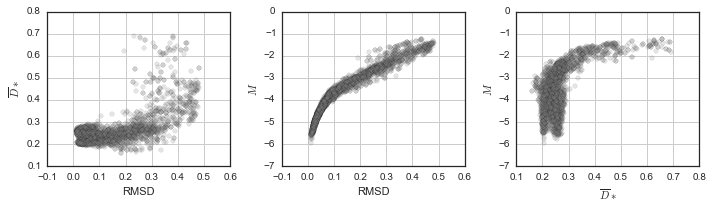

In [31]:
def scatter_misfit_stats(dataset):
    """
    Scatter plots of misfit vs. intermediate statistics. 
    """
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))

    col_pairs = (('RMSD', 'D_mean'),
                 ('RMSD', 'misfit'),
                 ('D_mean', 'misfit'))

    for (x, y), ax in zip(col_pairs, axes):
        dataset.plot(kind='scatter', x=x, y=y,
                     ax=ax, alpha=0.2, c='grey')
        plt.setp(ax, xlabel=na_labels[x],
                 ylabel=na_labels[y])

    fig.tight_layout()
    return fig, axes

fig, axes = scatter_misfit_stats(na_ensemble)

fig.savefig("figs_raw/misfit_vs_stats.svg")

## NA convergence

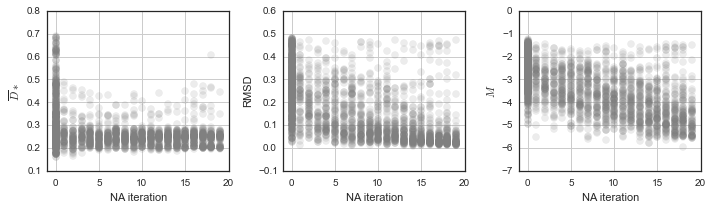

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for col, ax in zip(['D_mean', 'RMSD', 'misfit'], axes.flatten()):
    trace = na_ensemble.get(col)
    na_ensemble.plot(kind='scatter', x='NA_iter', y=col, ax=ax,
                     s=50, alpha=0.15, color='grey')
    plt.setp(ax, xlim=[-1, na_params['n_iter']])
    plt.setp(ax, ylabel=na_labels[col], xlabel='NA iteration')

fig.tight_layout()

fig.savefig("figs_raw/na_convergence.svg")

## Scatterplot matrix (ensemble and clusters)

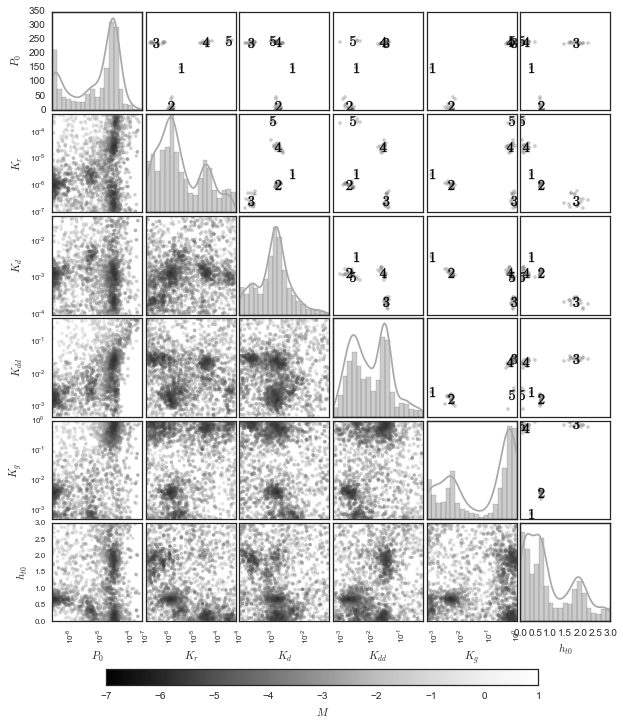

In [224]:
sns.set_context('notebook')


# sort and subset data (model parameters only)
na_sorted = na_ensemble.sort('misfit', ascending=False)
na_subset = na_sorted.loc[:, p_ranges.index]
iter_1plus = na_sorted['NA_iter'] > 0


# scatter matrix
carray = na_sorted['misfit']
cmap = mpl.cm.Greys_r
misfit_max = 1
misfit_min = -7

axes = pdplt.scatter_matrix(na_subset, c=carray,
                            edgecolors='none',
                            grid=False, s=50,
                            cmap=cmap, alpha=0.4,
                            vmax=misfit_max, vmin=misfit_min,
                            figsize=(10, 11))
fig = axes[0][0].figure


# colorbar
dummy_scatter = axes[0][0].scatter(
    carray, carray, c=carray,
    cmap=cmap,
    vmin=misfit_min,
    vmax=misfit_max,
)
cax = fig.add_axes([0.2, 0.05, 0.6, 0.02])
clb = plt.colorbar(dummy_scatter, cax=cax,
                   orientation='horizontal')
clb.set_label(na_labels[carray.name])

            
# diagonal subplots: models distributions
# for a single parameter
for i, col in enumerate(na_subset.columns):
    plt.setp(axes[i][i], axis_bgcolor='w')
    ax = axes[i][i]
    ax.clear()

    # don't include samples from 1st NA iteration
    col_data = na_sorted[iter_1plus].get(col)
    
    xlim = p_ranges.loc[col, ['min', 'max']].values.astype('f')
    
    # calculate KDE on log or linear scale
    if p_ranges.loc[col, 'log'] == True: 
        bins = np.logspace(*np.log10(xlim), num=20)
        kde_x = np.logspace(*np.log10(xlim), num=200)
        kde_gen = gaussian_kde(np.log10(col_data))
        kde_y = kde_gen.evaluate(np.log10(kde_x))
        plt.setp(ax, xscale='log')
    else:
        bins = np.linspace(*xlim, num=20)
        kde_x = np.linspace(*xlim, num=200)
        kde_gen = gaussian_kde(col_data)
        kde_y = kde_gen.evaluate(kde_x)
    
    sns.distplot(col_data, bins=bins, kde=False, hist=True, ax=ax,
                 color='grey')
    ax2 = ax.twinx()
    ax2.plot(kde_x, kde_y, c='darkgrey')
    plt.setp(ax2, yticks=[])
    plt.setp(ax, xlim=xlim)
    

# upper-triangle: clusters
#cluster_markers = ['o', 's', 'v', 'x', '+']
cluster_markers = ['$1$', '$2$', '$3$', '$4$', '$5$']
n_diag = len(na_subset.columns)
for i in range(n_diag):
    for j in range(n_diag):
        if i >= j:
            continue
        ax = axes[i][j]
        ax.clear()

for c in range(1, 6):
    na_subset_cluster = na_clusters[na_clusters['cluster'] == c]
    centroid = na_centroids.loc[c]
    for i in range(n_diag):
        icol = na_subset.columns[i]
        for j in range(n_diag):
            if i >= j:
                continue
            jcol = na_subset.columns[j]
            ax = axes[i][j]
            ax.scatter(na_subset_cluster[jcol],
                       na_subset_cluster[icol],
                       marker='.',
                       s=40, color='grey', alpha=0.4)
            ax.scatter(centroid[jcol], centroid[icol],
                       marker=cluster_markers[c-1],
                       s=100, color='k')

# axis limits (and log-scale if needed)
for i in range(n_diag):
    icol = na_subset.columns[i]
    ylim = p_ranges.loc[icol, ['min', 'max']]
    for j in range(n_diag):
        if i == j:
            continue
        jcol = na_subset.columns[j]
        xlim = p_ranges.loc[jcol, ['min', 'max']]
        plt.setp(axes[i][j], xlim=xlim, ylim=ylim)
        if p_ranges.loc[icol, 'log']:
            plt.setp(axes[i][j], yscale='log')
        if p_ranges.loc[jcol, 'log']:
            plt.setp(axes[i][j], xscale='log')


# axis labels
for i, col in enumerate(na_subset.columns):
    label = na_labels[col]
    plt.setp(axes[-1][i], xlabel=label)
    plt.setp(axes[i][0], ylabel=label)

# hide grid
for ax in axes.flatten():
    ax.grid(False)

# subplots spacing
fig.subplots_adjust(wspace=0.04, hspace=0.04, bottom=0.13)

fig.savefig("figs_raw/scatterplot_matrix.svg")

## Clustering

In [109]:
# apply clustering only to models with misfit lower than
misfit_max = -5.4
# remove the following variables of the dataset before clustering
drop_cols = ['misfit', 'D_mean', 'RMSD']

# select the subset, transform log search scales, normalize
# and select the variables used for clustering
na_misfit_sel = na_ensemble.misfit < misfit_max
na_subset = na_ensemble[na_misfit_sel]
na_subset.drop('NA_iter', axis=1, inplace=True)
na_subset_log = log_df(na_subset)
na_subset_norm = norm_df(na_subset_log)
na_subset_norm_p = na_subset_norm.drop(drop_cols, axis=1)

# compute the distance matrix (euclidian distances by default)
dist_matrix = distance.cdist(na_subset_norm_p, na_subset_norm_p)

# compute the link matrix (average method)
link_matrix = hierarchy.linkage(distance.squareform(dist_matrix),
                                method='average')

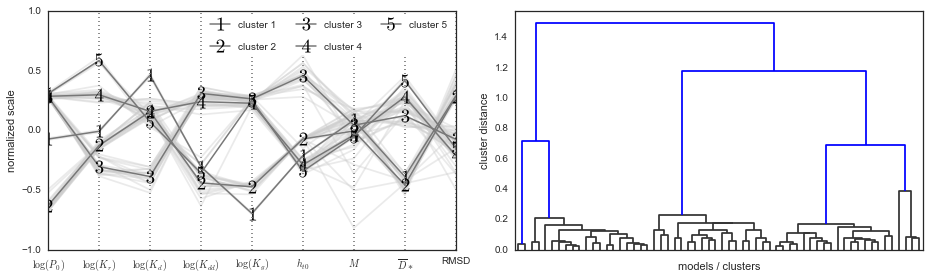

In [232]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# dendrogram
dist_tresh = 0.6  # cluster distance threshold 

cat_clr = ["#333333"] * 5
hierarchy.set_link_color_palette(cat_clr)

dendrogram = hierarchy.dendrogram(link_matrix,
                                  color_threshold=dist_tresh,
                                  labels=na_subset_norm.index,
                                  orientation='top', ax=axes[1])

plt.setp(axes[1], xlabel='models / clusters',
         ylabel='cluster distance', xticklabels=[])

# parallel plot
na_clusters_log = log_df(na_clusters)
na_clusters_lognorm = norm_df(na_clusters_log)
na_centroids_lognorm = na_clusters_lognorm.groupby('cluster').mean()

cluster_markers = ['$1$', '$2$', '$3$', '$4$', '$5$']
cat_clr = ["#CCCCCC"] * 5
 
pdplt.parallel_coordinates(
    na_clusters_lognorm.sort('cluster'), 'cluster',
    alpha=0.4, color=cat_clr, ax=axes[0],
    axvlines=False, xticks=range(9)
)
axes[0].legend_.remove()
axes[0].grid(False)

lines = []
for c, ctr in enumerate(na_centroids_lognorm.values):
    l, = axes[0].plot(ctr, linewidth=1.5,
                 label='cluster {}'.format(c + 1),
                 marker=cluster_markers[c], markersize=13,
                 markerfacecolor='k', color='#777777')
    lines.append(l)

leg = axes[0].legend(handles=lines, loc='upper right', ncol=3,
                     frameon=True, labelspacing=1.3)
leg.get_frame().set_color('w')

for x in range(9):
    axes[0].axvline(x=x, color='grey', linestyle=':')

xlbls = ['$\log({P_0})$', '$\log({K_r})$', '$\log({K_d})$', '$\log({K_{dd}})$',
         '$\log({K_g})$', '$h_{t0}$', '$M$', '$\overline{D}*$', 'RMSD',]
plt.setp(axes[0], ylabel='normalized scale',
         xticklabels=xlbls, ylim=[-1, 1])

fig.tight_layout()

fig.savefig("figs_raw/clustering.svg")